# A machine learning approach for the classification of cardiac arrhythmia
The aim of this project is to determine the type of arrhythmia from the ECG recordings.

Eleonora Detić

In [16]:
%matplotlib inline #ovo mi mozda kasnije stvara probleme
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import stats

### Data loading

In [2]:
df = pd.read_csv('data_arrhythmia.csv', delimiter=';')
df.dataframeName = 'data_arrhythmia.csv'

In [3]:
#data_fake = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/arrhythmia/arrhythmia.data', header=None)
with open("arrhythmia.names") as f:
    print(f.read())

1. Title: Cardiac Arrhythmia Database

2. Sources:
   (a) Original owners od Database:
       -- 1. H. Altay Guvenir, PhD., 
             Bilkent University,
             Department of Computer Engineering and Information Science,
             06533 Ankara, Turkey
             Phone: +90 (312) 266 4133
             Email: guvenir@cs.bilkent.edu.tr

       -- 2. Burak Acar, M.S.,
             Bilkent University, 
             EE Eng. Dept. 
             06533 Ankara, Turkey
             Email: buraka@ee.bilkent.edu.tr

       -- 2. Haldun Muderrisoglu, M.D., Ph.D., 
             Baskent University, 
             School of Medicine
             Ankara, Turkey

   (b) Donor: H. Altay Guvenir
              Bilkent University,
              Department of Computer Engineering and Information Science,
              06533 Ankara, Turkey
              Phone: +90 (312) 266 4133
              Email: guvenir@cs.bilkent.edu.tr

   (c) Date: January, 1998

3. Past Usage:
   1. H. Altay Guvenir, Bura

### Data survey

#### Descriptive statistics

age                                                   
     count       mean        std  min   25%   50%   75%   max
sex                                                          
0.0  203.0  47.546798  16.519761  0.0  37.5  47.0  59.0  80.0
1.0  249.0  45.594378  16.404173  1.0  34.0  46.0  58.0  83.0

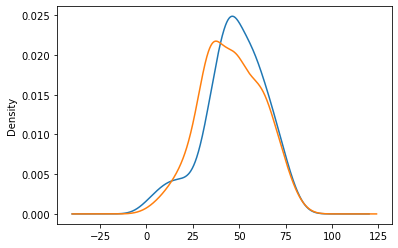

In [ ]:
df.groupby('sex').age.plot(kind='kde') #vizualni prikaz
df[["sex", "age"]].groupby("sex").describe() #deskriptivna statistika

The above results show the distribution graph and descriptive statistics, for both women and men.

#### Missing values

In [4]:
df.shape

(452, 280)

In [5]:
df.head()

,age,sex,height,weight,qrs_duration,p-r_interval,q-t_interval,t_interval,p_interval,qrs,...,KY,KZ,LA,LB,LC,LD,LE,LF,LG,diagnosis
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,...,0.0,12.2,-2.2,0.0,0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,...,0.0,13.1,-3.6,0.0,0,-0.1,3.9,25.4,62.8,7


In our data set, we have 452 patients and 279 features for each patient. Last column is interpreted as a number of heart arrhythmia claster. According to documentation, missing attribute values are distinguished with '?' so we will replace them with "NaN".

In [6]:
df = df.replace('?', np.NaN)
df.isna().sum().nlargest(10)

J               376
P                22
T                 8
QRST              1
heart_rate        1
age               0
sex               0
height            0
weight            0
qrs_duration      0
dtype: int64

As we can see, in column 'J' we have a lof of missing values, more than 80%, so we will drop that column.

In [7]:
df.drop(["J"], axis=1, inplace=True)

As for the other columns, since these variables are continuous, the first idea could be to hope for a normal distribution and then try to preserve the variability of the data by randomly simulate the missing values. <br> For this purpose, we perform well know **Kolmogorov–Smirnov** test.

In [8]:
print(stats.kstest(df[df['P'].notnull()]['P'].astype(int), 'norm'))
print(stats.kstest(df[df['T'].notnull()]['T'].astype(int), 'norm'))
print(stats.kstest(df[df['QRST'].notnull()]['QRST'].astype(int), 'norm'))
print(stats.kstest(df[df['heart_rate'].notnull()]['heart_rate'].astype(int), 'norm'))

KstestResult(statistic=0.9255811086972653, pvalue=0.0)
KstestResult(statistic=0.847749201067469, pvalue=0.0)
KstestResult(statistic=0.8168319201501881, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)


This assumption was obviously too ambitious. For all columns, the p value turned out to be very small and the test statistics very large. <br> So our conclusion is that at each standard level of significance, we reject the null hypothesis, that is, that our data **do not follow** a normal distribution. <br>
The next idea is standard. We will replace the missing values with the mean of each column.

In [9]:
imp= SimpleImputer(missing_values=np.NaN, strategy='mean')
idf=pd.DataFrame(imp.fit_transform(df))
idf.columns=df.columns
idf.index=df.index
df = idf

Finally, there are no more missing values in our data.

In [101]:
#df.isin([0]).sum(axis=0).nlargest(30) pitanje je dal izbacim te očite? -> ako su sve nule, il gotovo sve to mi ocito nista ne govori lol?

In [ ]:
#df.drop(["J","R'_wave","S'_wave", "AB", "AC", "AD","AE", "AF", "AG", "AL", "AN", "AO", "AP", "AR", "AS", "AT", "AZ", "AB'", "BC", "BD", "BE", "BG", "BH", "BP", "BR", "BS", "BT", "BU", "CA", "CD", "CE", "Cf", "CG", "CH", "CI", "CM","CN","CP","CR","CS","CT","CU","CV","DE","DF","DG","DH","DI","DJ","DR","DS","DT","DU","DV","DY","EG",
# "EH", "EL", "ER", "ET", "EU", "EV", "EY", "EZ", "FA", "FE", "FF", "FH", "FI", "FJ", "FK", "FL", "FM", "FR", "FS", "FU", "FV", "FY", "FZ", "GA",
# "GB", "GG", "GH", "HD", "HE", "HO", "IA", "IB", "IK", "IL", "IY", "JI", "JS", "JT", "KF", "KO", "KP", "LB", "LC", "T", "P", "QRST", "heart_rate"], axis=1, inplace=True)

## Principal component analysis

Before using PCA, the first step is scaling the features in our data. 

In [63]:
X = df.iloc[:,0:278].values
y = df.iloc[:,-1:].values
X = StandardScaler().fit_transform(X)

In [64]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

In [56]:
finalDf = pd.concat([principalDf, df[['diagnosis']]], axis = 1)

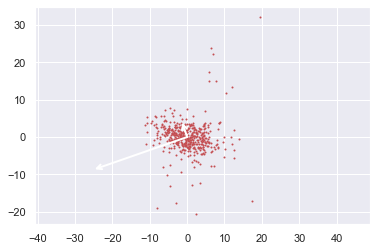

In [102]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',linewidth=2,shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)
plt.scatter(finalDf["PC1"],finalDf["PC2"], c="r",s=1)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 30 * np.sqrt(length) #obično skaliranje smjera vektora - provjeri ovaj dio
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

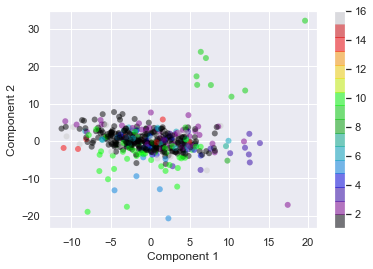

In [103]:
plt.scatter(finalDf["PC1"],finalDf["PC2"], c=finalDf.diagnosis, edgecolor='none', alpha=0.5,cmap=plt.cm.get_cmap('nipy_spectral', 16))
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar();

#### Scree plot

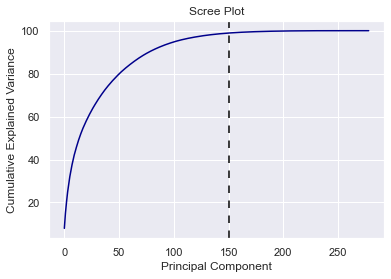

In [114]:
scaler = StandardScaler()
scaled_df=df.copy()
scaled_df=pd.DataFrame(scaler.fit_transform(scaled_df), columns=scaled_df.columns)
pca = PCA(n_components=279)
pca_fit = pca.fit(scaled_df)
PC_values = np.arange(pca.n_components_) + 1
plt.plot(np.cumsum(100 * pca.explained_variance_ratio_), color="darkblue")
#plt.title('Scree Plot') nisam sigurna jel ovo bas scree plot?
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.axvline(x=150, color="black", linestyle=(0, (5, 5)))
plt.show()

#print(pca.explained_variance_) #koliki smo postotak varijabilnosti objasnili

sada iz tog grafa zaključim da trebam 150 prvih komponenta i te feature uzmem

#### Cumulative variance graph

In [115]:
##uopce mi nije jasno kakav je to graf zadnji????? onak wtf zesci

### Classification 

#### Support Vector Machine

#### Logistic Regression Algorithm

#### K-Nearest Neighbors Algorithm

#### Random Forest Algorithm

## Conclusion 

blablabla
-moguci redoslijed mozda
Data transformation
Data cleaning
Data validation
Data augmentation
Feature enginerring